# Import the required modules.

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns; sns.set()

In [92]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from tensorflow.keras.callbacks import EarlyStopping

# Read data from attack and normal datasets.

In [139]:
data_attack = pd.read_csv('dataset_attack.csv')
data_normal = pd.read_csv('dataset_normal.csv')

In [140]:
data_all = pd.concat([data_attack, data_normal])
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   frame.encap_type  100000 non-null  int64  
 1   frame.len         100000 non-null  int64  
 2   frame.protocols   100000 non-null  object 
 3   ip.hdr_len        100000 non-null  int64  
 4   ip.len            100000 non-null  int64  
 5   ip.flags.rb       100000 non-null  int64  
 6   ip.flags.df       100000 non-null  int64  
 7   p.flags.mf        100000 non-null  int64  
 8   ip.frag_offset    100000 non-null  int64  
 9   ip.ttl            100000 non-null  int64  
 10  ip.proto          100000 non-null  int64  
 11  ip.src            100000 non-null  object 
 12  ip.dst            100000 non-null  object 
 13  tcp.srcport       100000 non-null  int64  
 14  tcp.dstport       100000 non-null  int64  
 15  tcp.len           100000 non-null  int64  
 16  tcp.ack           100000 n

# Drop non-numeric columns and 

In [141]:
data_all=data_all.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1)
data_all['class'] = np.where(data_all['class'] == 'normal', 0, 1)
X = data_all.drop(labels=['class'], axis=1)
Y = data_all['class']

In [142]:
mutual_info = mutual_info_classif(X, Y)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

tcp.dstport         0.543131
tcp.srcport         0.402781
tcp.ack             0.275080
tcp.window_size     0.265666
tcp.time_delta      0.213343
frame.len           0.208995
ip.len              0.206943
ip.ttl              0.189663
ip.flags.df         0.174877
ip.proto            0.161964
tcp.flags.ack       0.146666
tcp.len             0.100141
frame.encap_type    0.013074
ip.hdr_len          0.011742
tcp.flags.push      0.011662
tcp.flags.fin       0.003095
tcp.flags.ns        0.002194
tcp.flags.ecn       0.001800
p.flags.mf          0.001573
tcp.flags.cwr       0.001220
ip.flags.rb         0.000000
tcp.flags.res       0.000000
tcp.flags.urg       0.000000
ip.frag_offset      0.000000
tcp.flags.reset     0.000000
tcp.flags.syn       0.000000
dtype: float64

In [143]:
select_columns = mutual_info.sort_values(ascending=False).index[0:12]
print(select_columns)

Index(['tcp.dstport', 'tcp.srcport', 'tcp.ack', 'tcp.window_size',
       'tcp.time_delta', 'frame.len', 'ip.len', 'ip.ttl', 'ip.flags.df',
       'ip.proto', 'tcp.flags.ack', 'tcp.len'],
      dtype='object')


<AxesSubplot:>

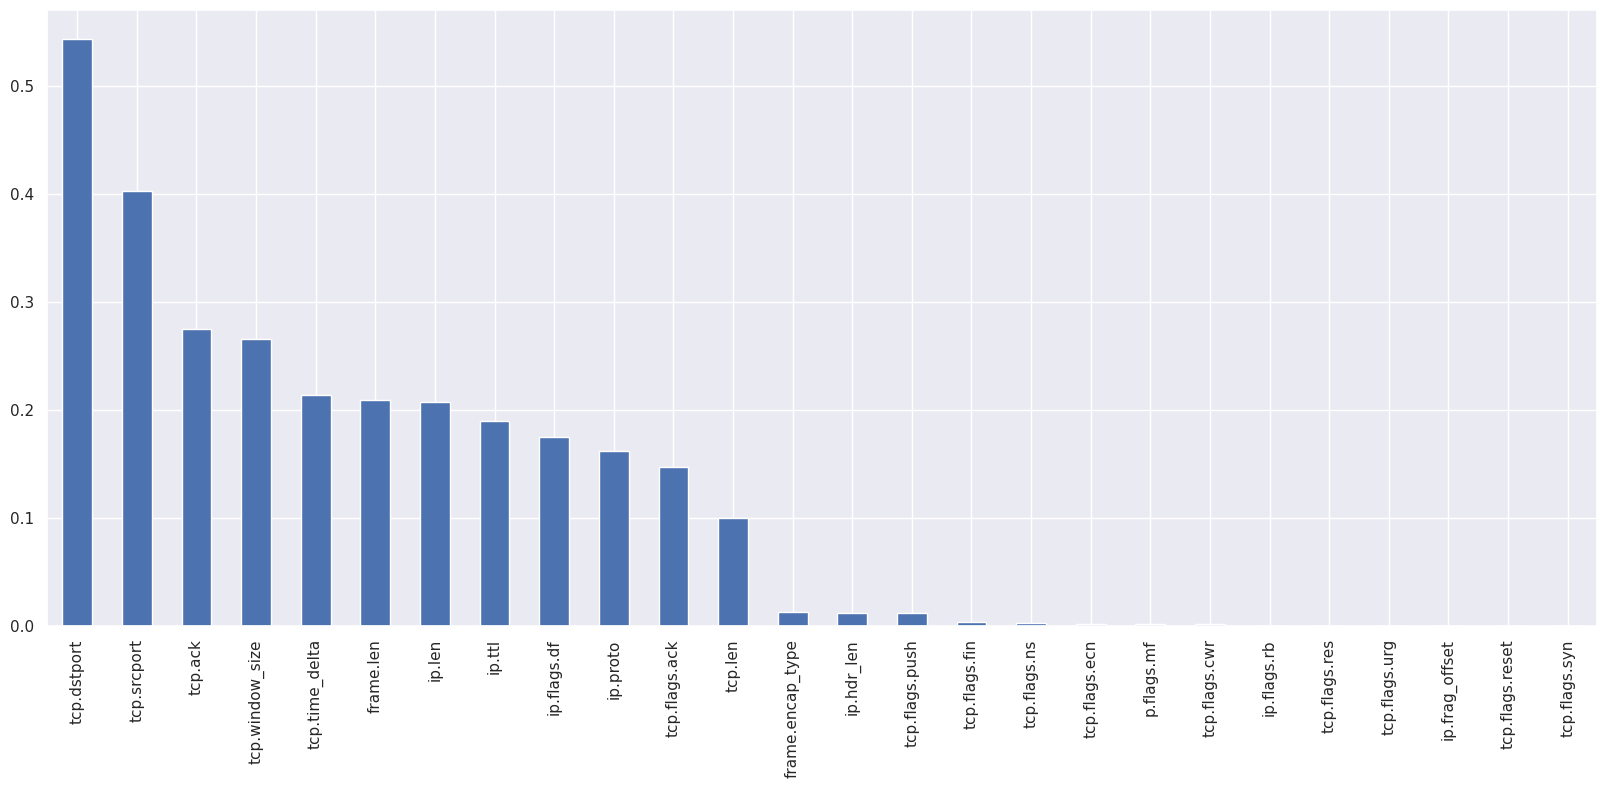

In [144]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [145]:
X= X[select_columns].values

# Standardise the data

In [100]:
scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(X)
X = scalar.transform(X)

In [101]:
X.shape

(100000, 12)

In [102]:
features = len(X[0])
samples = X.shape[0]
window_len = 25
input_len = samples - window_len
I = np.zeros((samples - window_len, window_len, features))

for i in range(input_len):
    temp = np.zeros((window_len, features))
    for j in range(i, i + window_len - 1):
        temp[j-i] = X[j]
    I[i] = temp

In [103]:
I.shape

(99975, 25, 12)

In [104]:
X_train, X_test, Y_train, Y_test = train_test_split(I, Y[24:99999], test_size = 0.2)
X_train = np.asarray(X_train).astype(np.float32)
Y_train = np.asarray(Y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
Y_test = np.asarray(Y_test).astype(np.float32)

The architecture used is 
![Model](model_brnn.png)

In [130]:
def create_model():
    model = Sequential()
    
    model.add(LSTM(64, activation='tanh', input_shape =(window_len, features), kernel_regularizer='l2'))
    model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [131]:
model = create_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 64)                19712     
                                                                 
 dense_16 (Dense)            (None, 128)               8320      
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 28,161
Trainable params: 28,161
Non-trainable params: 0
_________________________________________________________________


In [132]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
history = model.fit(X_train, Y_train, epochs = 40, validation_split=0.2, callbacks=[early_stop])

Epoch 1/40
2000/2000 [==============================] - 13s 6ms/step - loss: 0.2582 - accuracy: 0.9390 - val_loss: 0.1752 - val_accuracy: 0.9531
Epoch 2/40
2000/2000 [==============================] - 12s 6ms/step - loss: 0.1640 - accuracy: 0.9603 - val_loss: 0.1514 - val_accuracy: 0.9641
Epoch 3/40
2000/2000 [==============================] - 11s 6ms/step - loss: 0.1508 - accuracy: 0.9641 - val_loss: 0.1672 - val_accuracy: 0.9586
Epoch 4/40
2000/2000 [==============================] - 12s 6ms/step - loss: 0.1652 - accuracy: 0.9586 - val_loss: 0.1344 - val_accuracy: 0.9677
Epoch 5/40
2000/2000 [==============================] - 12s 6ms/step - loss: 0.1434 - accuracy: 0.9651 - val_loss: 0.1417 - val_accuracy: 0.9607
Epoch 6/40
2000/2000 [==============================] - 12s 6ms/step - loss: 0.1377 - accuracy: 0.9666 - val_loss: 0.1777 - val_accuracy: 0.9495
Epoch 7/40
2000/2000 [==============================] - 12s 6ms/step - loss: 0.1375 - accuracy: 0.9660 - val_loss: 0.1263 - val_ac

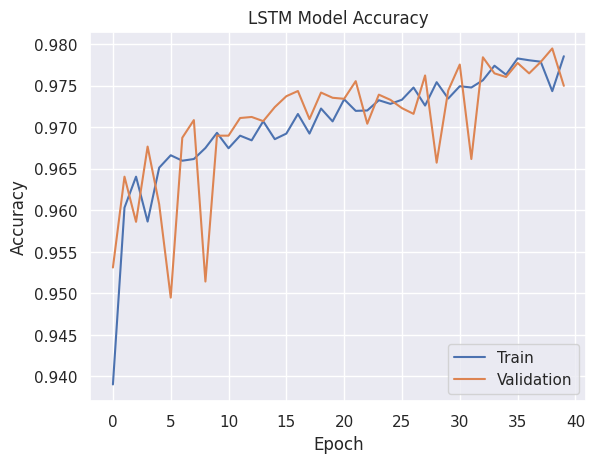

In [133]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('LSTM Model Accuracy.png')
plt.show()

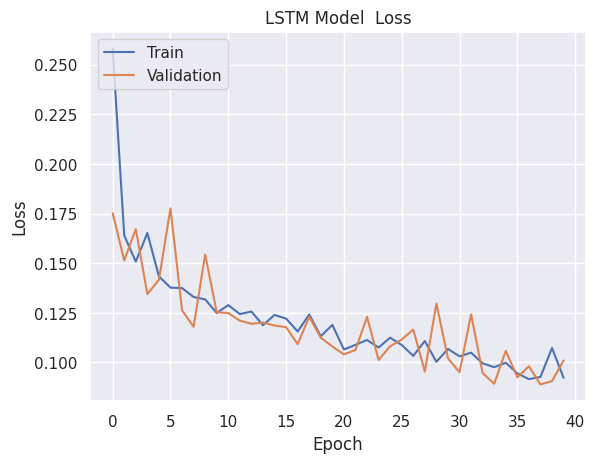

In [134]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('LSTM Model Loss.png')
plt.show()


In [135]:
predict = model.predict(X_test, verbose=1)

625/625 [==============================] - 1s 2ms/step


#  Calculate True positive,True negetive,False positive and False negetive values. Create Heatmap.

In [136]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = Y_test.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1


In [137]:
tpr = tp / (tp + fn)
fnr = fn / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (tn + fp)
print('tpr', tpr)
print('fnr', fnr)
print('tnr', tnr)
print('fpr', fpr)

tpr 0.9879182156133829
fnr 0.012081784386617101
tnr 0.9602366404810396
fpr 0.03976335951896033


In [138]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 97.36%
